In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import joblib
import os

In [2]:
data_path = '../data/processed/'
models_path = '../src/models/'

os.makedirs(models_path, exist_ok=True)

# Cargar los datos preprocesados
print("Cargando datos...")
df = pd.read_csv(data_path + 'preprocessed_data_30.csv')
#df = pd.read_csv(data_path + 'preprocessed_data_3.csv')


Cargando datos...


In [3]:
if 'label' in df.columns:
    X = df.drop(columns=['label', 'label_encoded'] if 'label_encoded' in df.columns else ['label'])
else:
    X = df.drop(columns=['label_encoded'] if 'label_encoded' in df.columns else [])

if 'filename' in X.columns:
    X = X.drop(columns=['filename'])

if 'label_encoded' in df.columns:
    y = df['label_encoded']
else:
    y = LabelEncoder().fit_transform(df['label'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Forma de los datos de entrenamiento: {X_train.shape}")
print(f"Forma de los datos de prueba: {X_test.shape}")

results = []


Forma de los datos de entrenamiento: (800, 57)
Forma de los datos de prueba: (200, 57)


In [4]:
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    print(f"\nEntrenando modelo {model_name}...")
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy del modelo {model_name}: {accuracy:.4f}")
    
    # Informe de clasificación
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Guardar el modelo
    joblib.dump(model, os.path.join(models_path, f'{model_name}.pkl'))

    results.append({
        'model_name': model_name,
        'accuracy': accuracy,
        'confusion_matrix': cm
    })
    
    return model, accuracy, cm


In [5]:
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Matriz de confusión - {model_name}')
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    plt.show()


## **SVM**

In [6]:
print("\n" + "="*50)
print("Entrenando modelo SVM...")
print("="*50)

# Búsqueda de hiperparámetros para SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid_svm,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)

print(f"Mejores parámetros para SVM: {svm_grid.best_params_}")
print(f"Mejor puntuación de validación cruzada: {svm_grid.best_score_:.4f}")

# Evaluar el mejor modelo SVM
best_svm = svm_grid.best_estimator_
svm_model, svm_accuracy, svm_cm = evaluate_model(best_svm, 'svm', X_train, X_test, y_train, y_test)



Entrenando modelo SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores parámetros para SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor puntuación de validación cruzada: 0.7375

Entrenando modelo svm...
Accuracy del modelo svm: 0.7650

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        20
           1       0.74      0.85      0.79        20
           2       0.85      0.85      0.85        20
           3       0.69      0.55      0.61        20
           4       0.80      0.80      0.80        20
           5       0.77      0.85      0.81        20
           6       0.94      0.85      0.89        20
           7       0.68      0.65      0.67        20
           8       0.65      0.75      0.70        20
           9       0.72      0.65      0.68        20

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.76       200
we

## **KNN**

In [7]:
print("\n" + "="*50)
print("Entrenando modelo KNN...")
print("="*50)

# Búsqueda de hiperparámetros para KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

knn_grid.fit(X_train, y_train)

print(f"Mejores parámetros para KNN: {knn_grid.best_params_}")
print(f"Mejor puntuación de validación cruzada: {knn_grid.best_score_:.4f}")

best_knn = knn_grid.best_estimator_
knn_model, knn_accuracy, knn_cm = evaluate_model(best_knn, 'knn', X_train, X_test, y_train, y_test)


Entrenando modelo KNN...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Mejores parámetros para KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Mejor puntuación de validación cruzada: 0.6988

Entrenando modelo knn...
Accuracy del modelo knn: 0.7300

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.60      0.69        20
           1       0.83      1.00      0.91        20
           2       0.72      0.90      0.80        20
           3       0.71      0.50      0.59        20
           4       0.74      0.70      0.72        20
           5       0.88      0.70      0.78        20
           6       0.82      0.70      0.76        20
           7       0.64      0.80      0.71        20
           8       0.60      0.60      0.60        20
           9       0.64      0.80      0.71        20

    accuracy                           0.73       200
   macro avg       0.74      0.73   

## **Redes Neuronales**

In [8]:
print("\n" + "="*50)
print("Entrenando modelo de Red Neuronal...")
print("="*50)

# Búsqueda de hiperparámetros para la Red Neuronal
param_grid_nn = {
    'hidden_layer_sizes': [(100,), (100, 50), (100, 100), (200,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

nn_grid = GridSearchCV(
    MLPClassifier(max_iter=300, random_state=42),
    param_grid_nn,
    cv=StratifiedKFold(n_splits=3),  
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

nn_grid.fit(X_train, y_train)

print(f"Mejores parámetros para la Red Neuronal: {nn_grid.best_params_}")
print(f"Mejor puntuación de validación cruzada: {nn_grid.best_score_:.4f}")

best_nn = nn_grid.best_estimator_
nn_model, nn_accuracy, nn_cm = evaluate_model(best_nn, 'neural_network', X_train, X_test, y_train, y_test)




Entrenando modelo de Red Neuronal...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


C:\Users\rebe1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Mejores parámetros para la Red Neuronal: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Mejor puntuación de validación cruzada: 0.7262

Entrenando modelo neural_network...
Accuracy del modelo neural_network: 0.7050

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        20
           1       0.89      0.85      0.87        20
           2       0.65      0.85      0.74        20
           3       0.60      0.45      0.51        20
           4       0.68      0.75      0.71        20
           5       0.74      0.85      0.79        20
           6       1.00      0.70      0.82        20
           7       0.71      0.60      0.65        20
           8       0.57      0.65      0.60        20
           9       0.52      0.55      0.54        20

    accuracy                           0.70       200
   macro avg       0.72      0.70   

C:\Users\rebe1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Comparación de modelos


Comparación de modelos
1. svm: 0.7650
2. knn: 0.7300
3. neural_network: 0.7050


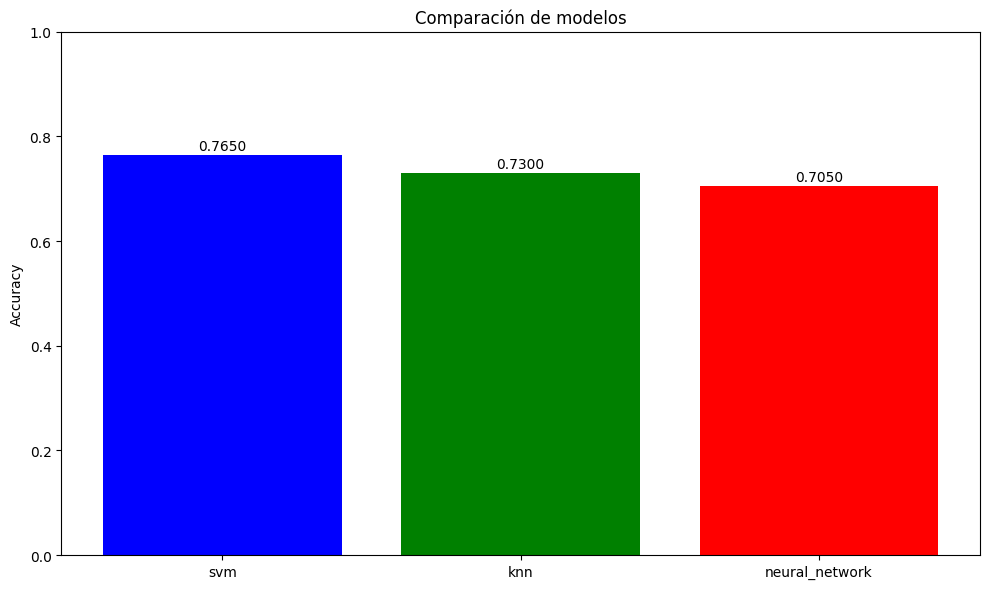

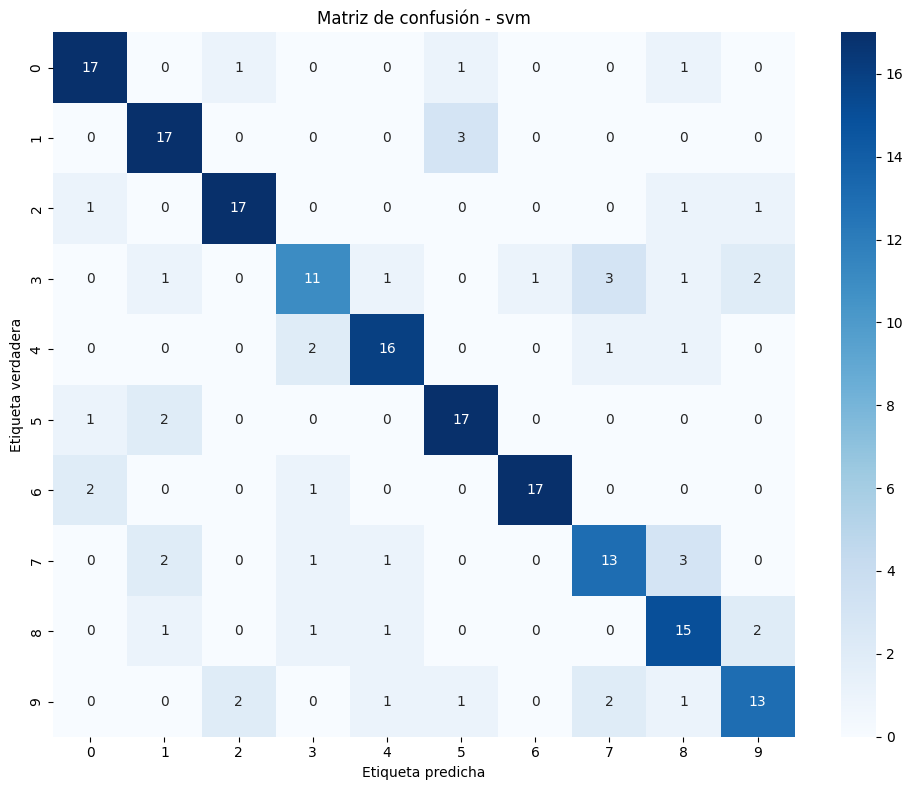

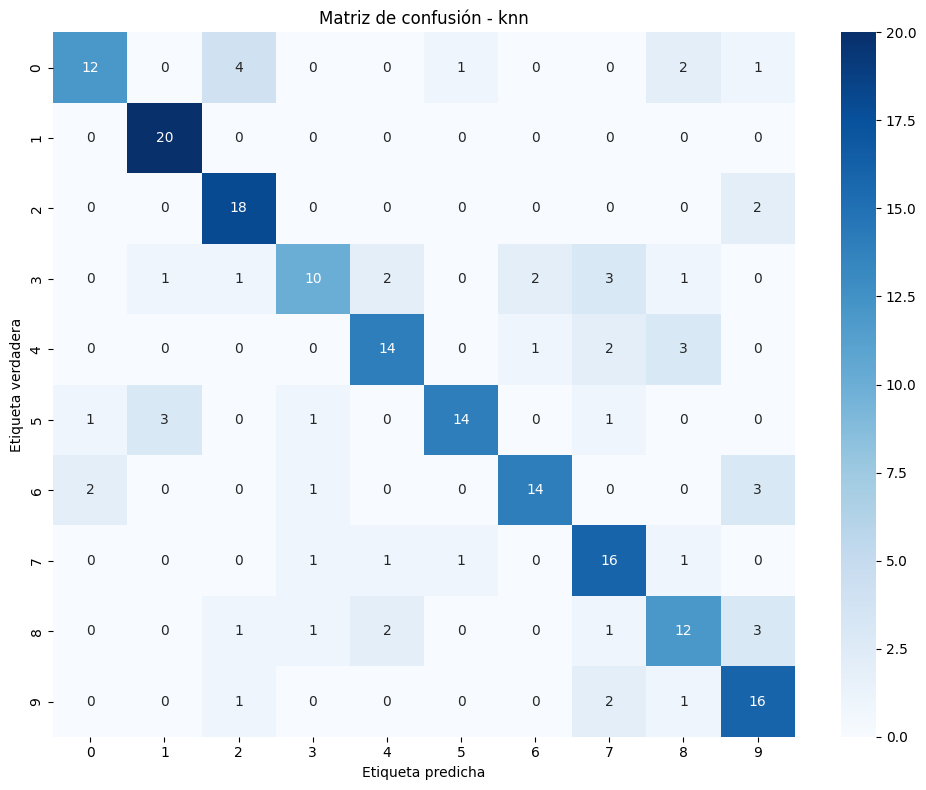

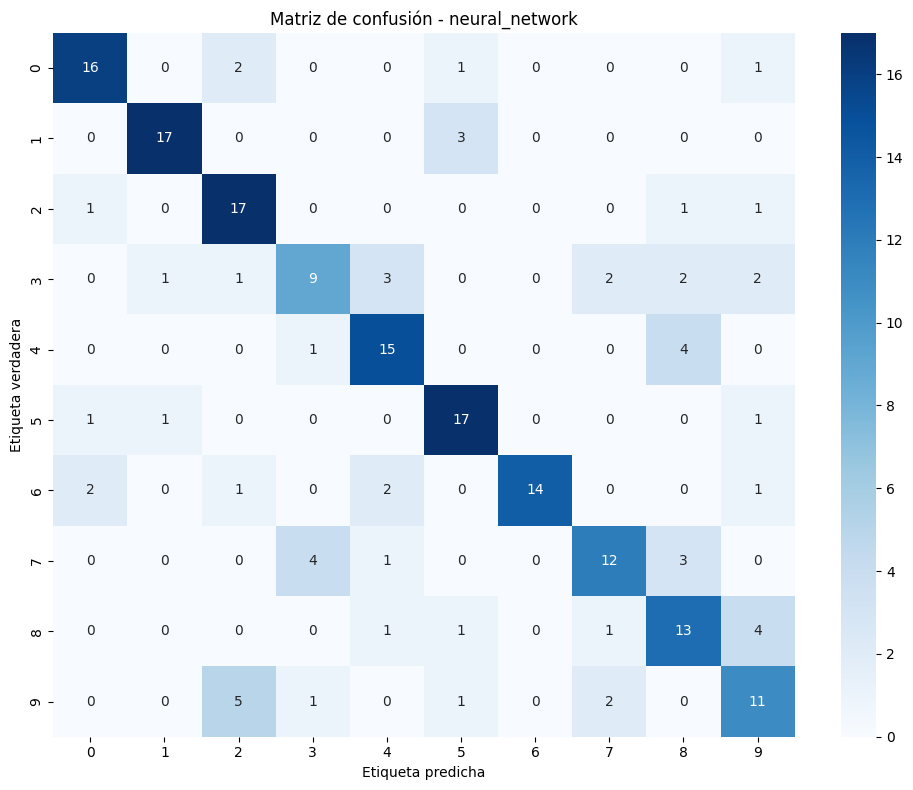

Proceso completado correctamente.


In [9]:
print("\n" + "="*50)
print("Comparación de modelos")
print("="*50)

# Ordenar los modelos por precisión
results.sort(key=lambda x: x['accuracy'], reverse=True)

for i, result in enumerate(results):
    print(f"{i+1}. {result['model_name']}: {result['accuracy']:.4f}")

# Visualizar los resultados
plt.figure(figsize=(10, 6))
model_names = [result['model_name'] for result in results]
accuracies = [result['accuracy'] for result in results]

plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.ylabel('Accuracy')
plt.title('Comparación de modelos')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()


summary = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

try:
    label_encoder = joblib.load(os.path.join(models_path, 'label_encoder.pkl'))
except:
    label_encoder = LabelEncoder()
    if 'label' in df.columns:
        label_encoder.fit(df['label'])
        joblib.dump(label_encoder, os.path.join(models_path, 'label_encoder.pkl'))
    elif 'label_encoded' in df.columns:
        print("La columna 'label' no existe, pero se encontró 'label_encoded'. Usando 'label_encoded' para el LabelEncoder.")
        label_encoder.fit(df['label_encoded'])
        joblib.dump(label_encoder, os.path.join(models_path, 'label_encoder.pkl'))
    else:
        print("Ni 'label' ni 'label_encoded' existen en el DataFrame. No se puede entrenar el LabelEncoder.")
        label_encoder = None

# Visualizar matrices de confusión
class_names = label_encoder.classes_
for result in results:
    plot_confusion_matrix(result['confusion_matrix'], class_names, result['model_name'])

print("Proceso completado correctamente.")